In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C import CAdaptive_C_RK4
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    coeff = 2 * num_electrons / S.trace() * S
    return coeff @ linalg.funm(inv_S @ H, 
                    lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

In [3]:
def plot_results_fd_vs_c(num_electrons, fd, c):
    H = c.H
    S = c.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    fignum = 1
    plt.figure(fignum)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, S)[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c.rho, S)[::-1], 'r^-', 
             label="Can. WOM")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/rk2_C_pop.png", format='png', dpi=300)
    print(c.beta)
    
    # Plot increments of dbeta that our method took
    fignum += 1
    plt.figure(fignum)
    plt.title("Variable step method in action - " +str(num_electrons) + " electrons")
    plt.plot(c.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(c.num_electron_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(c.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_chem_pot.png", format='png', dpi=300)

    # Check beta vs step size
    fignum += 1
    plt.figure(fignum)
    beta_vals = np.cumsum(c.beta_increments)
    plt.plot(c.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.semilogy(beta_vals, (c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_energy_vs_steps.png", format='png', dpi=300)
    
    # Plot heat capacity
    """
    fignum += 1
    plt.figure(fignum)
    plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons")
    t_vals = 1 / np.cumsum(c.beta_increments) * 1 / 3.168e-6
    temp = np.pi ** 2 / 2 * 2/ 13.49e4 * t_vals + 12*np.pi**4/5 * 3.168e-6 * t_vals ** 3 / 433 ** 3
    #alpha = temp[-1] / c.cv[-1]
    plt.plot(t_vals[95:], np.array(c.cv[95:])/num_electrons*2)
    plt.plot(t_vals[95:], temp[95:], '--')
    plt.xlabel("T")
    plt.ylabel("C_v/k")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_cv.png", format='png', dpi=300)
    """
    n = int(beta_vals.shape[0] - 5)
    fignum += 1
    plt.figure(fignum)
    #plt.title("Heat capacity vs temp - " + str(num_electrons) + " electrons (sqrt approach)")
    t_vals = 1 / beta_vals * 1 / 3.168e-6
    temp = np.pi ** 2 / 2 * 2/ 13.49e4 * t_vals 
    #temp += 12*np.pi**4/5 * 3.168e-6 * t_vals ** 3 / 433 ** 3
    plt.plot(t_vals[n:], np.array(c.cv[n:])/num_electrons*2, 'r', 
             label='WOM')
    plt.plot(t_vals[n:], temp[n:], 'k--', label='Exact')
    plt.xlabel("$\\mathrm{T}(\\mathrm{K})$")
    plt.ylabel("$\\mathrm{C}_v/k$")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/rk2_C_cv.png", format='png', dpi=300)

In [4]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# Define path for matrices
matrices_path = "larger_matrices/"

### 32 electrons

In [6]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

E, V = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 32
beta = 100
dbeta = 0.75

In [7]:
sqrt_c_16 = CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-2, tol=0)
sqrt_c_16.propagate(beta)
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, sqrt_c_16.beta, sqrt_c_16.mu)

funm result may be inaccurate, approximate err = 1


105.53641180948733


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, ord

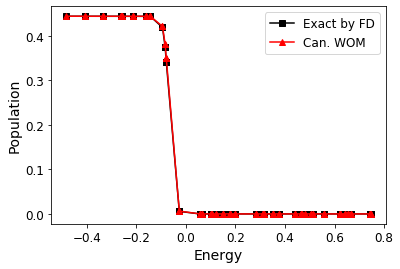

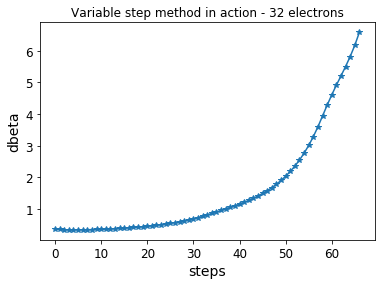

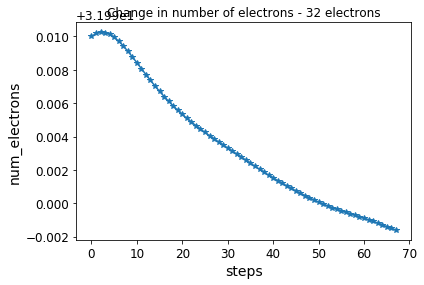

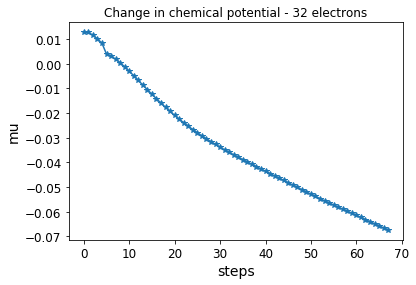

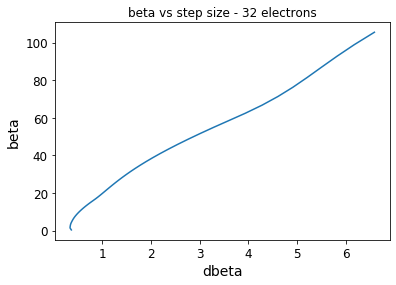

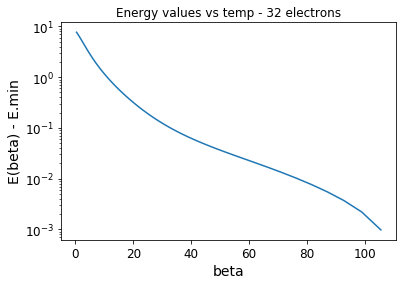

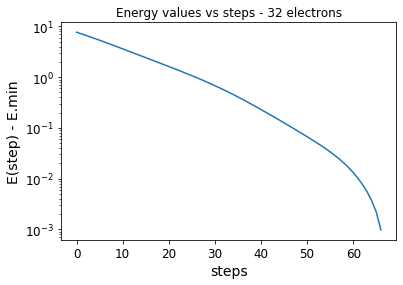

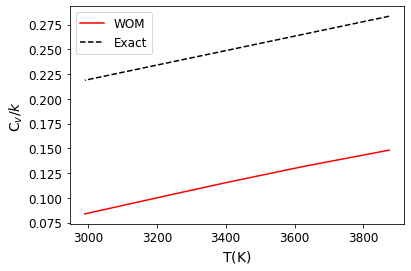

In [8]:
plot_results_fd_vs_c(num_electrons, ferm_exact_16, sqrt_c_16)

In [9]:
# We want to confirm that our method is able to go forwards and backwards
test_c = CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, rho=sqrt_c_16.rho, 
                                omega=sqrt_c_16.omega,
                               dbeta=-dbeta, epsilon=1e-2, num_electrons=num_electrons,
                              beta=sqrt_c_16.beta)
beta_final = sqrt_c_16.beta - 10
test_c.back_propagate(beta_final)

ZeroDivisionError: float division by zero

In [ ]:
test_c.dbeta = -test_c.dbeta
test_c.previous_dbeta = 0
beta = 100
test_c.propagate(beta)
test_c.beta

In [ ]:
plt.plot(E, linalg.eigvalsh(test_c.rho, S_16)[::-1],
         'x-', label='After 2nd propagation')
plt.plot(E, linalg.eigvalsh(ferm_exact_16, S_16)[::-1], '--', label='Exact')
plt.legend(numpoints=1)

In [ ]:
# Now we want to check what happens when we start at the ground state and 
# increase the temperature a bit
inv_V = linalg.inv(V)
diag_H = np.diag(E)
inv_S_16 = linalg.inv(S_16)
beta = 150
mu = test_c.mu
x = V @ diag_H @ inv_V
coeff = 2 * num_electrons  
#test_P = coeff @ V @ linalg.funm(diag_H,
#                lambda _: 1 / (1 + np.exp(beta * (_ - mu)))) @ inv_V
test_P = S_16 @ V @ np.diag(E < E[num_electrons])  @ inv_V + 1e-5 * S_16
test_P *= num_electrons / np.trace(test_P)

plt.plot(E, linalg.eigvalsh(test_P, S_16)[::-1], 's-')

In [ ]:
np.trace(test_P)

In [ ]:
# Now create a case with a starting point of beta=150
gs_c_16 = CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, rho=test_P, 
                                omega=linalg.sqrtm(test_P),
                               dbeta=-dbeta, epsilon=1e-2, num_electrons=num_electrons,
                               beta=beta)
gs_c_16.back_propagate(beta - 135)

In [ ]:
np.trace(gs_c_16.rho)

In [ ]:
plt.plot(E, linalg.eigvalsh(gs_c_16.rho, S_16)[::-1])
plt.plot(E, linalg.eigvalsh(test_P, S_16)[::-1], 's-')
plt.title("From $\\beta=150$ to $\\beta=125$")

In [ ]:
gs_c_16.dbeta *= -1
gs_c_16.previous_dbeta = 0
gs_c_16.propagate(beta)

In [ ]:
plt.plot(E, linalg.eigvalsh(ferm_exact_16, S_16)[::-1], 's-', label='Exact')
plt.plot(E, linalg.eigvalsh(gs_c_16.rho, S_16)[::-1], 'x-', label='Reiterating')
plt.title("From $\\beta=125$ to $\\beta=150$")
plt.legend(numpoints=1)

### 108 electrons

In [ ]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

beta = 100
dbeta = 0.75

# Define num_electrons and beta
num_electrons = 108

In [ ]:
sqrt_c_54 = CAdaptive_C_RK4_sqrt(ovlp=S_54, H=H_54, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=4e-2)
sqrt_c_54.propagate(beta)
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, sqrt_c_54.beta, sqrt_c_54.mu)

In [ ]:
plot_results_fd_vs_c(num_electrons, ferm_exact_54, sqrt_c_54)

In [ ]:
x = [1, 2]
y = [sqrt_c_16.count, sqrt_c_54.count]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54'])
ax.set_xticks(x)
plt.savefig("larger_matrices/sqrt_figs/C/c_acc_count.png", format='png', dpi=300)

In [ ]:
print(sqrt_c_16.num_electron_list[-1])
print(sqrt_c_54.num_electron_list[-1])
#np.save("larger_matrices/sqrt_figs/rk2_rho", sqrt_c_16.rho)
rk4_rho = np.load("larger_matrices/sqrt_figs/rk4_rho.npy")
plt.plot(E, linalg.eigvalsh(rk4_rho, S_16)[::-1], 's-', label='rk4')
plt.plot(E, linalg.eigvalsh(sqrt_c_16.rho, S_16)[::-1], 'x-', label='rk2')
plt.legend(numpoints=1)

In [ ]:
sqrt_c_16.beta_increments[0]

In [ ]:
0.2/32*100

RK2: 
(31.96138630948215+0j)
(107.86129064230545+0j)

RK4:
(32.00054992846267+0j)
(108.00056706768257+0j)

### 256 electrons

In [ ]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 256

In [ ]:
sqrt_c_128 = CAdaptive_C_RK4_sqrt(ovlp=S_128, H=H_128, num_electrons=num_electrons, dbeta=dbeta, epsilon=1e-2)
sqrt_c_128.propagate(beta)
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, sqrt_c_128.beta, sqrt_c_128.mu)

In [ ]:
plot_results_fd_vs_c(num_electrons, ferm_exact_128, sqrt_c_128)

In [ ]:
x = [1, 2, 3]
y = [sqrt_c_16.count, sqrt_c_54.count, sqrt_c_128.count]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54', '128'])
ax.set_xticks(x)
plt.savefig("larger_matrices/sqrt_figs/C/c_acc_count.png", format='png', dpi=300)

### 500 electrons

In [ ]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 500

In [ ]:
sqrt_c_250 = CAdaptive_C_RK4_sqrt(ovlp=S_250, H=H_250, num_electrons=num_electrons, dbeta=dbeta, epsilon=1e-2)
sqrt_c_250.propagate(beta)
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, sqrt_c_250.beta, sqrt_c_250.mu)

In [ ]:
plot_results_fd_vs_c(num_electrons, ferm_exact_250, sqrt_c_250)

In [ ]:
x = [1, 2, 3, 4]
y = [len(sqrt_c_16.energy_vals), len(sqrt_c_54.energy_vals), len(sqrt_c_128.energy_vals), \
     len(sqrt_c_250.energy_vals)]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
ax.set_xlabel("Num atoms")
#plt.title("GC Steps vs Num Atoms")
plt.savefig("larger_matrices/sqrt_figs/C/c_steps_vs_size.png", format='png', dpi=300)